# Tardiness

- Tardiness = 0, wenn der Auftrag rechtzeitig oder sogar vorzeitig fertiggestellt wurde.
- Tardiness > 0, wenn der Auftrag später fertiggestellt wird als ursprünglich vorgesehen
- berücksichtigt nur positive Abweichungen, also nur tatsächliche Verspätungen.

$$
T_j = \max(0,\; C_j - d_j)
$$


- $T_j$: Tardiness (Verspätung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $T_j > 0$: Job ist **verspätet**  
- $T_j = 0$: Job ist **pünktlich oder zu früh**  
- Frühfertigungen werden **nicht bestraft**, sondern zu $0$ gesetzt

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pulp
import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics

import time

In [2]:
max_time = 60 * 60 * 5 # 5 h

max_time = 60 * 15 # 15 min

In [3]:
basic_data_path = get_path("data", "basic")
df_instance = pd.read_csv(basic_data_path / "00_instance.csv")

df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 1, u_b_mmax= 0.94, shuffle = True)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
315,Job_031,5,M1,28
316,Job_031,6,M6,46
317,Job_031,7,M5,46
318,Job_031,8,M7,72


In [4]:
df_jobs = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)
df_jobs

,Job,Arrival,Deadline
0,Job_000,0.00,1323.0
1,Job_001,81.32,1789.0
2,Job_002,101.67,2004.0
3,Job_003,142.01,2335.0
4,Job_004,177.21,1493.0
...,...,...,...
27,Job_027,1390.30,3195.0
28,Job_028,1391.02,2714.0
29,Job_029,1410.87,2727.0
30,Job_030,1423.44,2746.0


## a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$  
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**  
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [5]:

def solve_jssp_sum_tardiness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, solver: str = 'HiGHS', 
                             epsilon: float = 0.0, sort_ascending: bool = False, **solver_args) -> pd.DataFrame:
    """
    Minimiert die Summe der Tardiness (Verspätungen) aller Jobs.
    Zielfunktion: sum_j [ max(0, Endzeit_j - Deadline_j) ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - epsilon: Pufferzeit zwischen Operationen auf derselben Maschine.
    - sort_ascending: Sortiert Jobs nach Deadline.
    - **solver_args: Weitere Solver-Parameter wie msg=True, timeLimit=1200 etc.

    Rückgabe:
    - DataFrame mit ['Job','Operation','Arrival','Deadline','Machine',
      'Start','Processing Time','End','Tardiness'].
    """

    # 1. Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # BigM berechnen (Worst Case)
    sum_proc_time = df_jssp["Processing Time"].sum()
    min_arrival = min(arrival.values())
    max_deadline = max(deadline.values())
    num_machines = df_jssp["Machine"].nunique()

    bigM_raw = max_deadline - min_arrival + sum_proc_time / math.sqrt(num_machines)
    bigM = math.ceil(bigM_raw / 1000) * 1000
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. Modell
    prob = pulp.LpProblem("JSSP_SumTardiness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=arrival[jobs[j]])
        for j in range(n)
    }

    tard = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0)
        for j in range(n)
    }

    # 4. Zielfunktion
    prob += pulp.lpSum(tard[j] for j in range(n))

    # 5. Technologische Reihenfolge & Tardiness
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev
        d_last = seq[-1][2]
        prob += ends[j] == starts[(j, len(seq) - 1)] + d_last
        prob += tard[j] >= ends[j] - deadline[job]

    # 6. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 7. Solverwahl
    solver_args.setdefault("msg", True)
    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")
    
    prob.solve(cmd)
    objective_value = pulp.value(prob.objective)

    # 8. Ergebnisse
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Tardiness": max(0, round(ed - deadline[job], 2))
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 9. Logging
    print("\nSolver-Informationen:")
    print(f"  Summe Tardiness         : {round(objective_value, 4)}")
    print(f"  Solver-Status           : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen        : {len(prob.variables())}")
    print(f"  Anzahl Constraints      : {len(prob.constraints)}")

    return df_schedule


In [6]:
starting_time = time.time()

# Scheduling
df_plan_sum_t = solve_jssp_sum_tardiness(df_jssp, df_jobs, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_t

BigM: 9000

Solver-Informationen:
  Summe Tardiness         : 188.64
  Solver-Status           : Optimal
  Anzahl Variablen        : 5344
  Anzahl Constraints      : 10272

Scheduling-Dauer: 5 Minuten und 0.28 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,1323.0,M0,0.00,29.0,29.00,0.00
1,Job_000,1,0.00,1323.0,M1,29.00,78.0,107.00,0.00
2,Job_000,2,0.00,1323.0,M2,107.00,9.0,116.00,0.00
3,Job_000,3,0.00,1323.0,M3,116.00,36.0,152.00,0.00
4,Job_000,4,0.00,1323.0,M4,152.00,49.0,201.00,0.00
...,...,...,...,...,...,...,...,...,...
315,Job_024,5,1238.36,3432.0,M8,3216.41,52.0,3268.41,0.00
316,Job_024,6,1238.36,3432.0,M7,3268.41,85.0,3353.41,0.00
317,Job_024,7,1238.36,3432.0,M3,3353.41,98.0,3451.41,19.41
318,Job_024,8,1238.36,3432.0,M9,3451.41,22.0,3473.41,41.41


In [7]:
show.count_column_grouped(df_plan_sum_t, 'Tardiness')

label
0            312
0 - 60         6
60 - 120       2
120 - 180      0
>180           0
Name: count, dtype: int64

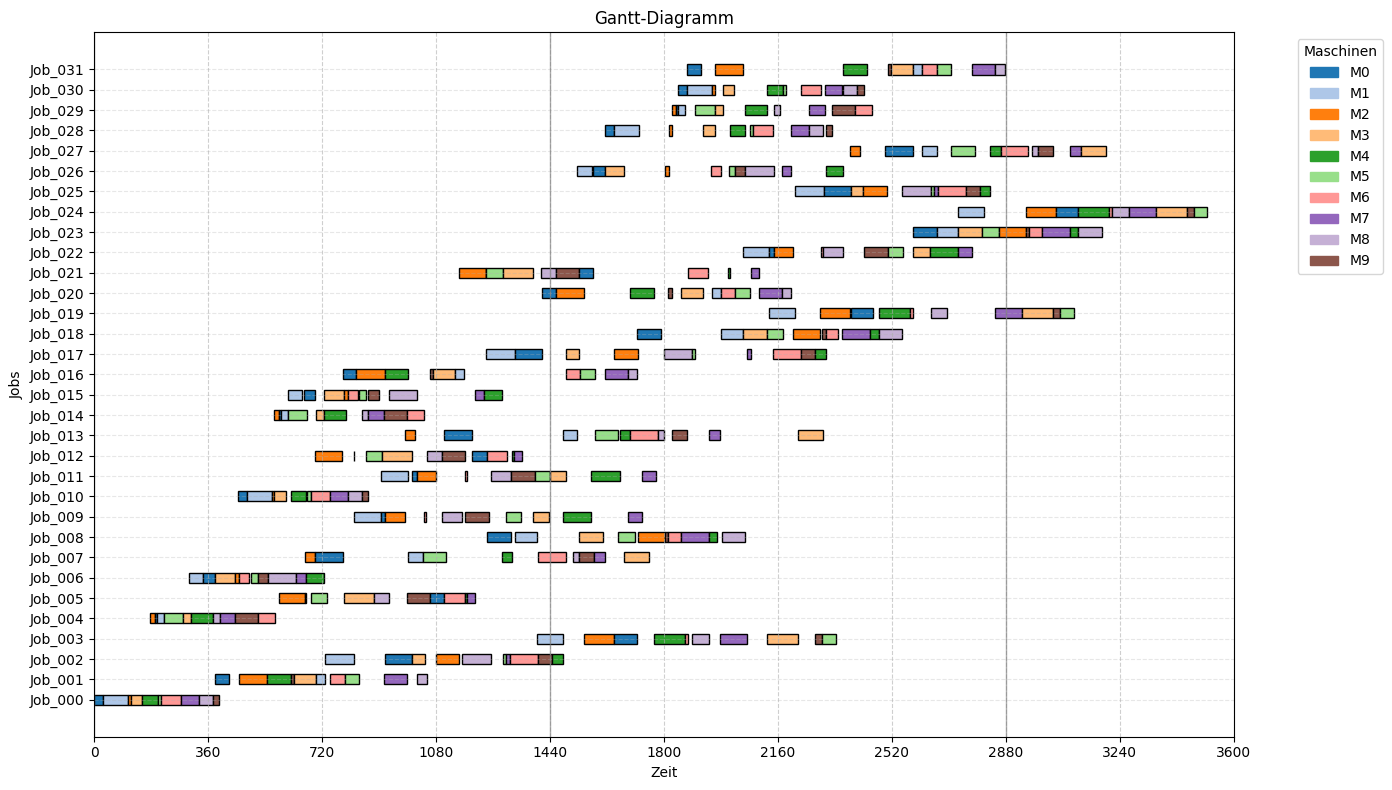

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [8]:
df_plan = df_plan_sum_t

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$  
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**  
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.


In [9]:

def solve_jssp_max_tardiness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, solver: str = 'HiGHS', 
                             epsilon: float = 0.0, sort_ascending: bool = False, **solver_args) -> pd.DataFrame:
    """
    Minimiert die maximale Tardiness (Verspätung) unter allen Jobs.
    Zielfunktion: max_j [ max(0, Endzeit_j - Deadline_j) ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - epsilon: Pufferzeit zwischen Operationen auf derselben Maschine.
    - sort_ascending: Sortiert die Jobs nach Deadline.
    - **solver_args: Weitere Solver-Parameter wie msg=True, timeLimit=1200 etc.

    Rückgabe:
    - DataFrame mit ['Job','Operation','Arrival','Deadline','Machine',
      'Start','Processing Time','End','Tardiness'].
    """

    # 1. Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # BigM berechnen (Worst Case)
    sum_proc_time = df_jssp["Processing Time"].sum()
    min_arrival = min(arrival.values())
    max_deadline = max(deadline.values())
    num_machines = df_jssp["Machine"].nunique()
    
    bigM_raw = max_deadline - min_arrival + sum_proc_time / math.sqrt(num_machines)
    bigM = math.ceil(bigM_raw / 1000) * 1000
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. LP-Modell
    prob = pulp.LpProblem("JSSP_MaxTardiness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=arrival[jobs[j]])
        for j in range(n)
    }

    tard = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0)
        for j in range(n)
    }

    max_tard = pulp.LpVariable("max_tardiness", lowBound=0)

    # Zielfunktion
    prob += max_tard

    # 4. Technologische Reihenfolge & Tardiness
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev
        d_last = seq[-1][2]
        prob += ends[j] == starts[(j, len(seq) - 1)] + d_last
        prob += tard[j] >= ends[j] - deadline[job]
        prob += max_tard >= tard[j]

    # 5. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 6. Solverwahl
    solver_args.setdefault("msg", True)
    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")

    prob.solve(cmd)
    objective_value = pulp.value(prob.objective)

    # 7. Ergebnis extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Tardiness": max(0, round(ed - deadline[job], 2))
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 8. Logging
    print("\nSolver-Informationen:")
    print(f"  Maximale Tardiness      : {round(objective_value, 4)}")
    print(f"  Solver-Status           : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen        : {len(prob.variables())}")
    print(f"  Anzahl Constraints      : {len(prob.constraints)}")

    return df_schedule


In [10]:
starting_time = time.time()

# Scheduling
df_plan_max_t = solve_jssp_max_tardiness(df_jssp, df_jobs, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_max_t

BigM: 9000

Solver-Informationen:
  Maximale Tardiness      : 62.68
  Solver-Status           : Optimal
  Anzahl Variablen        : 5345
  Anzahl Constraints      : 10304

Scheduling-Dauer: 5 Minuten und 0.32 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,1323.0,M0,0.00,29.0,29.00,0.00
1,Job_000,1,0.00,1323.0,M1,29.00,78.0,107.00,0.00
2,Job_000,2,0.00,1323.0,M2,107.00,9.0,116.00,0.00
3,Job_000,3,0.00,1323.0,M3,116.00,36.0,152.00,0.00
4,Job_000,4,0.00,1323.0,M4,152.00,49.0,201.00,0.00
...,...,...,...,...,...,...,...,...,...
315,Job_024,5,1238.36,3432.0,M8,3180.68,52.0,3232.68,0.00
316,Job_024,6,1238.36,3432.0,M7,3232.68,85.0,3317.68,0.00
317,Job_024,7,1238.36,3432.0,M3,3317.68,98.0,3415.68,0.00
318,Job_024,8,1238.36,3432.0,M9,3415.68,22.0,3437.68,5.68


In [11]:
show.count_column_grouped(df_plan_max_t, 'Tardiness')

label
0            314
0 - 60         5
60 - 120       1
120 - 180      0
>180           0
Name: count, dtype: int64

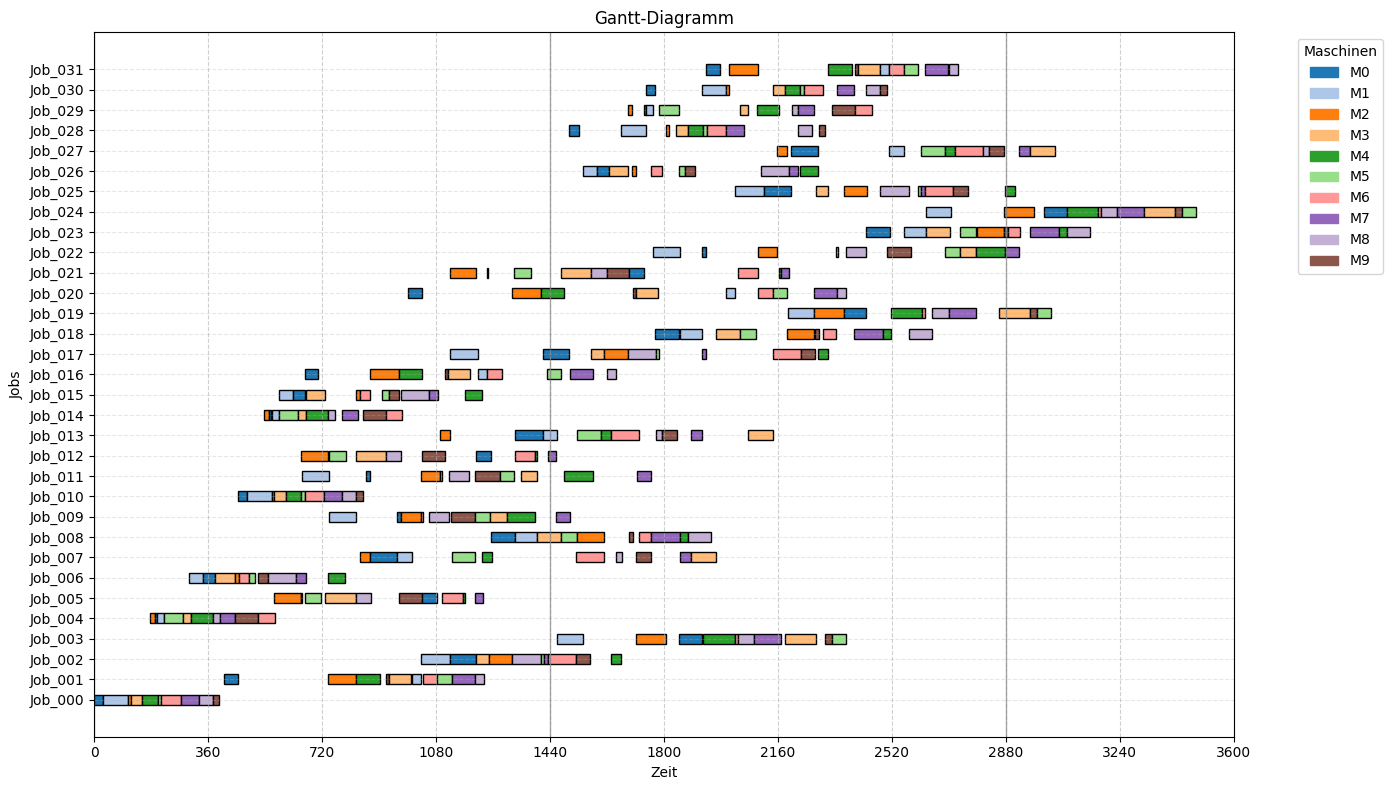

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [12]:
df_plan = df_plan_max_t

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)